In [25]:
from typing import Callable, List, Tuple
import collections
from PIL import Image
import os
import torch
import catalyst
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

from catalyst.dl import utils
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl import SupervisedRunner

import segmentation_models_pytorch as smp

from pathlib import Path
from models.unets import unet_resnet
from dataflow.dataloaders import get_train_val_loaders
from dataflow.visualisations import tensor_to_rgb
from dataflow.transforms import get_train_augmentation, get_validation_augmentation, prepare_batch_fp32, get_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path('/media/wwymak/Storage/spacenet')
summary_data = data_dir / 'summary_ids.csv'
summary_data_df = pd.read_csv(summary_data)


In [3]:
debug=False
batch_size = 4
val_batch_size = batch_size * 2
num_workers = 12
val_interval = 3
accumulation_steps = 4

model, preprocessing_fn = unet_resnet("efficientnet-b0")
train_loader, val_loader, test_loader = get_train_val_loaders(
    summary_data_filepath=summary_data,
    train_transforms= get_train_augmentation(is_display=False, image_size=512, normalisation_fn=None),
    val_transforms= get_validation_augmentation(is_display=False, image_size=512, normalisation_fn=None),
    batch_size=batch_size,
    num_workers = num_workers
)

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = val_loader

(4999, 9)
(4249, 9)


In [4]:

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}



learning_rate = 0.0005
encoder_learning_rate = 0.00005

# model, preprocessing_function = unet_resnet('efficientnet-b0')
# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)


In [5]:
# from torch_lr_finder import LRFinder
# from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
# class CustomTrainIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data["image"], batch_data["mask"]
    
# custom_train_iter = CustomTrainIter(train_loader)
# lr_finder = LRFinder(model, optimizer, criterion=IoULoss(), device="cuda")
# lr_finder.range_test(custom_train_iter, end_lr=100, num_iter=100, step_mode="exp")

/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)




Learning rate search finished. See the graph with {finder_name}.plot()


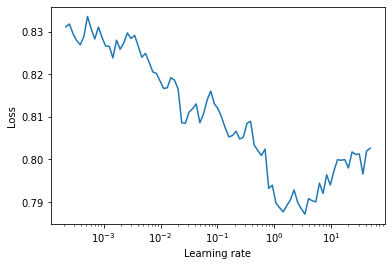

In [6]:
# lr_finder.plot()

In [10]:
# learning_rate = 1e-3
# base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
# optimizer = Lookahead(base_optimizer)
# # scheduler = optim.lr_scheduler.CyclicLR(optimizer, factor=0.25, patience=2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=[x['lr'] * 10 for x in model_params], steps_per_epoch=len(train_loader), epochs=50)

In [6]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d-%H")

'2020-08-02-19'

In [7]:


num_epochs = 50
logdir = data_dir /"experiment_tracking"/"unets"/ f'{datetime.now().strftime("%Y-%m-%d-%H")}_512_512_inputs'

device = utils.get_device()
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [8]:
%load_ext tensorboard.notebook
%tensorboard --logdir {logdir}

In [11]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True,
)

1/50 * Epoch (train):   0% 1/854 [00:00<13:59,  1.02it/s, dice=0.275, iou=0.160, loss=2.298, loss_bce=0.916, loss_dice=0.725, loss_iou=0.840]

/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



1/50 * Epoch (train): 100% 854/854 [02:01<00:00,  7.02it/s, dice=0.363, iou=0.222, loss=2.067, loss_bce=0.814, loss_dice=0.637, loss_iou=0.778]
1/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.84it/s, dice=0.127, iou=0.068, loss=2.519, loss_bce=0.892, loss_dice=0.873, loss_iou=0.932]
[2020-08-02 19:11:52,772] 
1/50 * Epoch 1 (_base): lr=2.000e-05 | momentum=0.9500
1/50 * Epoch 1 (train): dice=0.2989 | iou=0.1775 | loss=2.2279 | loss_bce=0.8804 | loss_dice=0.7011 | loss_iou=0.8225
1/50 * Epoch 1 (valid): dice=0.3181 | iou=0.1933 | loss=2.1588 | loss_bce=0.8378 | loss_dice=0.6819 | loss_iou=0.8067


/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1206: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



2/50 * Epoch (train): 100% 854/854 [02:02<00:00,  6.98it/s, dice=0.424, iou=0.269, loss=1.891, loss_bce=0.730, loss_dice=0.576, loss_iou=0.731]
2/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 22.80it/s, dice=0.136, iou=0.073, loss=2.466, loss_bce=0.843, loss_dice=0.864, loss_iou=0.927]
[2020-08-02 19:13:59,999] 
2/50 * Epoch 2 (_base): lr=2.000e-05 | momentum=0.9500
2/50 * Epoch 2 (train): dice=0.3222 | iou=0.1939 | loss=2.1308 | loss_bce=0.8085 | loss_dice=0.6778 | loss_iou=0.8061
2/50 * Epoch 2 (valid): dice=0.3346 | iou=0.2054 | loss=2.0797 | loss_bce=0.7746 | loss_dice=0.6654 | loss_iou=0.7946
3/50 * Epoch (train): 100% 854/854 [02:06<00:00,  6.75it/s, dice=0.304, iou=0.180, loss=2.126, loss_bce=0.763, loss_dice=0.696, loss_iou=0.820]
3/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.58it/s, dice=0.145, iou=0.078, loss=2.395, loss_bce=0.772, loss_dice=0.855, loss_iou=0.922]
[2020-08-02 19:16:12,155] 
3/50 * Epoch 3 (_base): lr=2.000e-05 | momentum=0.9500
3/50 * Epoch 3 (train): 

15/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 23.89it/s, dice=0.151, iou=0.082, loss=2.317, loss_bce=0.688, loss_dice=0.849, loss_iou=0.918]
[2020-08-02 19:40:42,222] 
15/50 * Epoch 15 (_base): lr=2.000e-05 | momentum=0.9500
15/50 * Epoch 15 (train): dice=0.3595 | iou=0.2211 | loss=1.9424 | loss_bce=0.6537 | loss_dice=0.6405 | loss_iou=0.7789
15/50 * Epoch 15 (valid): dice=0.3619 | iou=0.2259 | loss=1.9295 | loss_bce=0.6466 | loss_dice=0.6381 | loss_iou=0.7741
16/50 * Epoch (train): 100% 854/854 [01:59<00:00,  7.17it/s, dice=0.401, iou=0.251, loss=1.872, loss_bce=0.654, loss_dice=0.599, loss_iou=0.749]
16/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.78it/s, dice=0.153, iou=0.083, loss=2.316, loss_bce=0.689, loss_dice=0.847, loss_iou=0.917]
[2020-08-02 19:42:46,497] 
16/50 * Epoch 16 (_base): lr=2.000e-05 | momentum=0.9500
16/50 * Epoch 16 (train): dice=0.3594 | iou=0.2211 | loss=1.9418 | loss_bce=0.6530 | loss_dice=0.6406 | loss_iou=0.7789
16/50 * Epoch 16 (valid): dice=0.3629

29/50 * Epoch (train): 100% 854/854 [02:01<00:00,  7.04it/s, dice=0.293, iou=0.171, loss=2.067, loss_bce=0.664, loss_dice=0.707, loss_iou=0.829]
29/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.68it/s, dice=0.151, iou=0.082, loss=2.314, loss_bce=0.684, loss_dice=0.849, loss_iou=0.918]
[2020-08-02 20:09:49,878] 
29/50 * Epoch 29 (_base): lr=2.001e-05 | momentum=0.9500
29/50 * Epoch 29 (train): dice=0.3614 | iou=0.2228 | loss=1.9337 | loss_bce=0.6473 | loss_dice=0.6386 | loss_iou=0.7772
29/50 * Epoch 29 (valid): dice=0.3641 | iou=0.2277 | loss=1.9221 | loss_bce=0.6423 | loss_dice=0.6359 | loss_iou=0.7723
30/50 * Epoch (train): 100% 854/854 [01:55<00:00,  7.42it/s, dice=0.382, iou=0.236, loss=1.887, loss_bce=0.632, loss_dice=0.618, loss_iou=0.764]
30/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.39it/s, dice=0.150, iou=0.081, loss=2.316, loss_bce=0.685, loss_dice=0.850, loss_iou=0.919]
[2020-08-02 20:11:50,143] 
30/50 * Epoch 30 (_base): lr=2.001e-05 | momentum=0.9500
30/50 * Epoc

In [12]:
# for now, just test on the validation iamges
import numpy as np
# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=val_loader, resume=f"{logdir}/checkpoints/best.pth")
)))



In [13]:
test_images = []
test_masks = []
for batch in val_loader:
    test_images.append(batch['image'])
    test_masks.append(batch['mask'])

In [14]:
test_images = np.vstack(test_images)
test_masks = np.vstack(test_masks)

In [15]:
test_images = np.moveaxis(test_images, 1, -1)

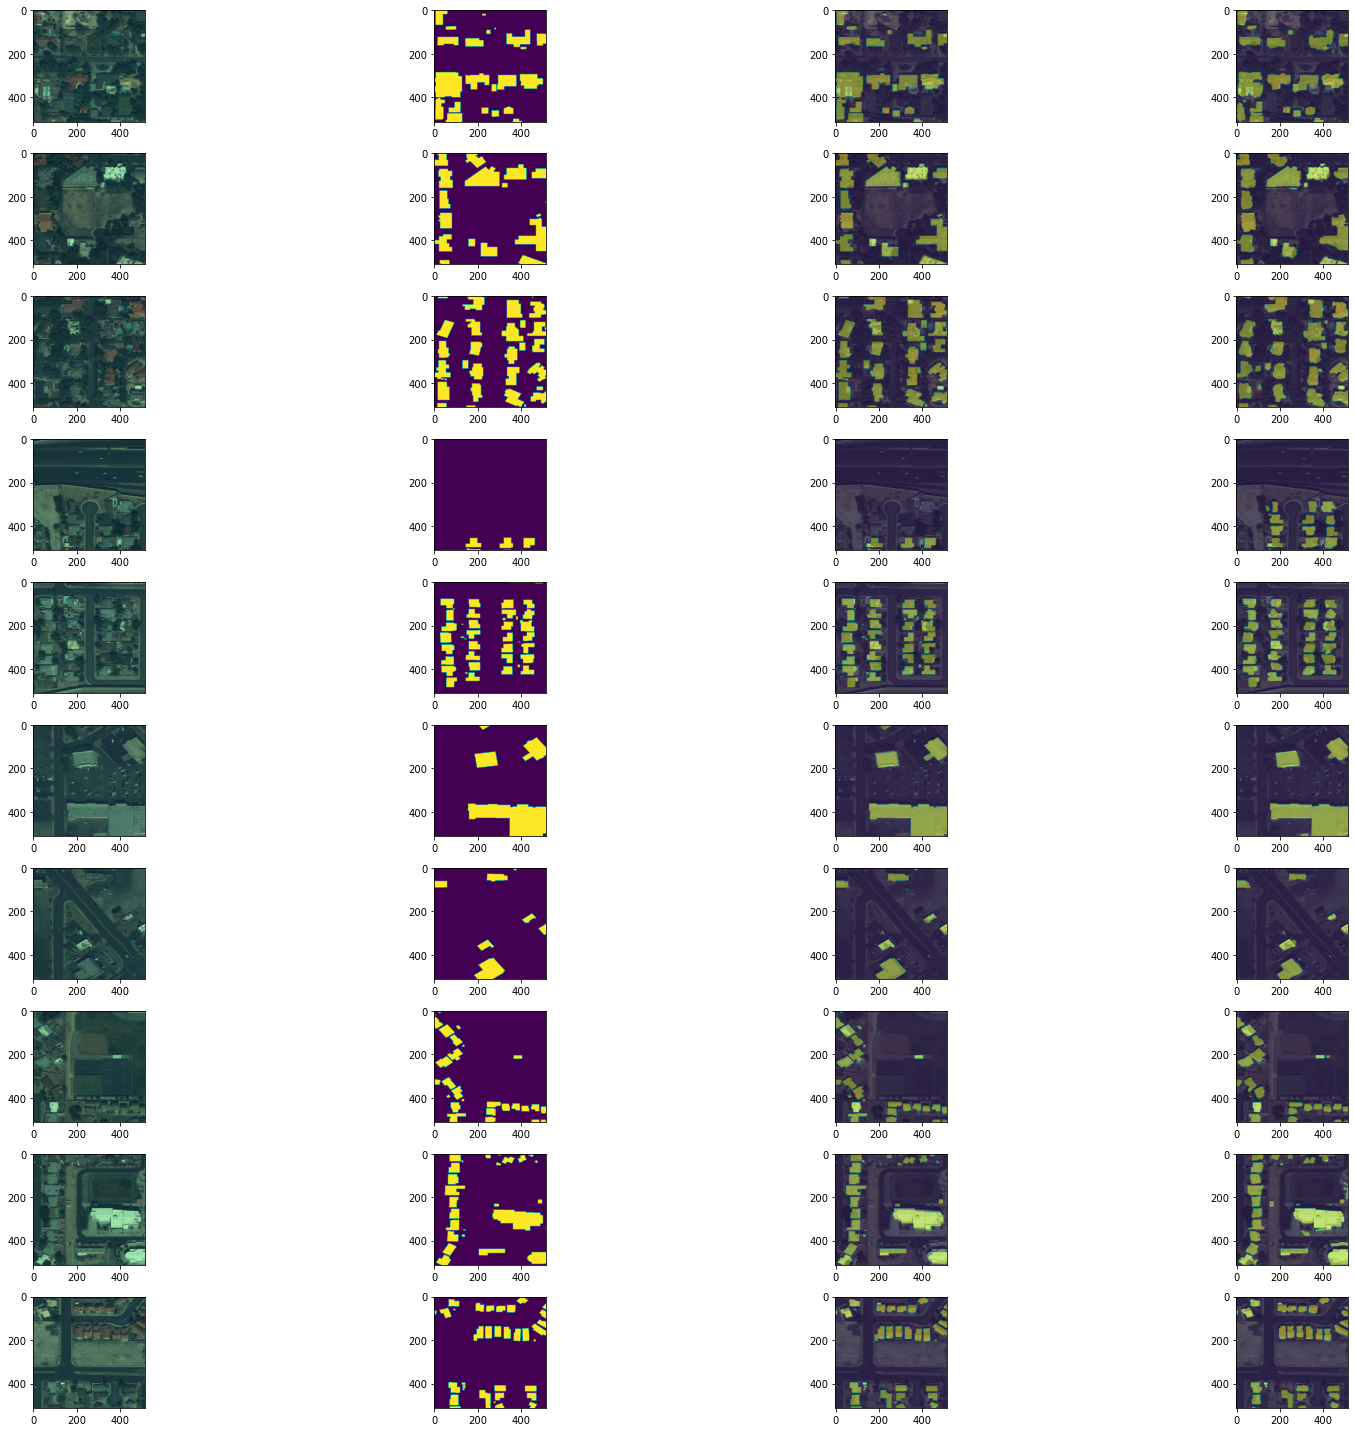

In [16]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(5 * 5, 4 * 5))
for i in range(10):
    img_normed = (test_images[i] - test_images[i].min())/(test_images[i].max() - test_images[i].min())
    axs[i, 0].imshow(img_normed)
    axs[i, 1].imshow(test_masks[i].squeeze())
    axs[i, 2].imshow(img_normed)
    axs[i, 2].imshow(test_masks[i].squeeze(), alpha=0.4)
    axs[i, 3].imshow(img_normed)
    axs[i, 3].imshow(predictions[i].squeeze(), alpha=0.4)
plt.tight_layout();

In [26]:
predictions_dir = data_dir / "predictions" / logdir.stem
predictions_dir.mkdir(exist_ok=True)
validation_dir = predictions_dir /"validations"
validation_dir.mkdir(exist_ok=True)
test_dir = predictions_dir /"test"
test_dir.mkdir(exist_ok=True)

In [112]:
for i in range(len(test_masks)):
    filename = f"{Path(val_loader.dataset.mask_filepath_list[i]).stem}.png"
    Image.fromarray(predictions[i].squeeze()).resize((650, 650)).convert("L").save(validation_dir/filename)

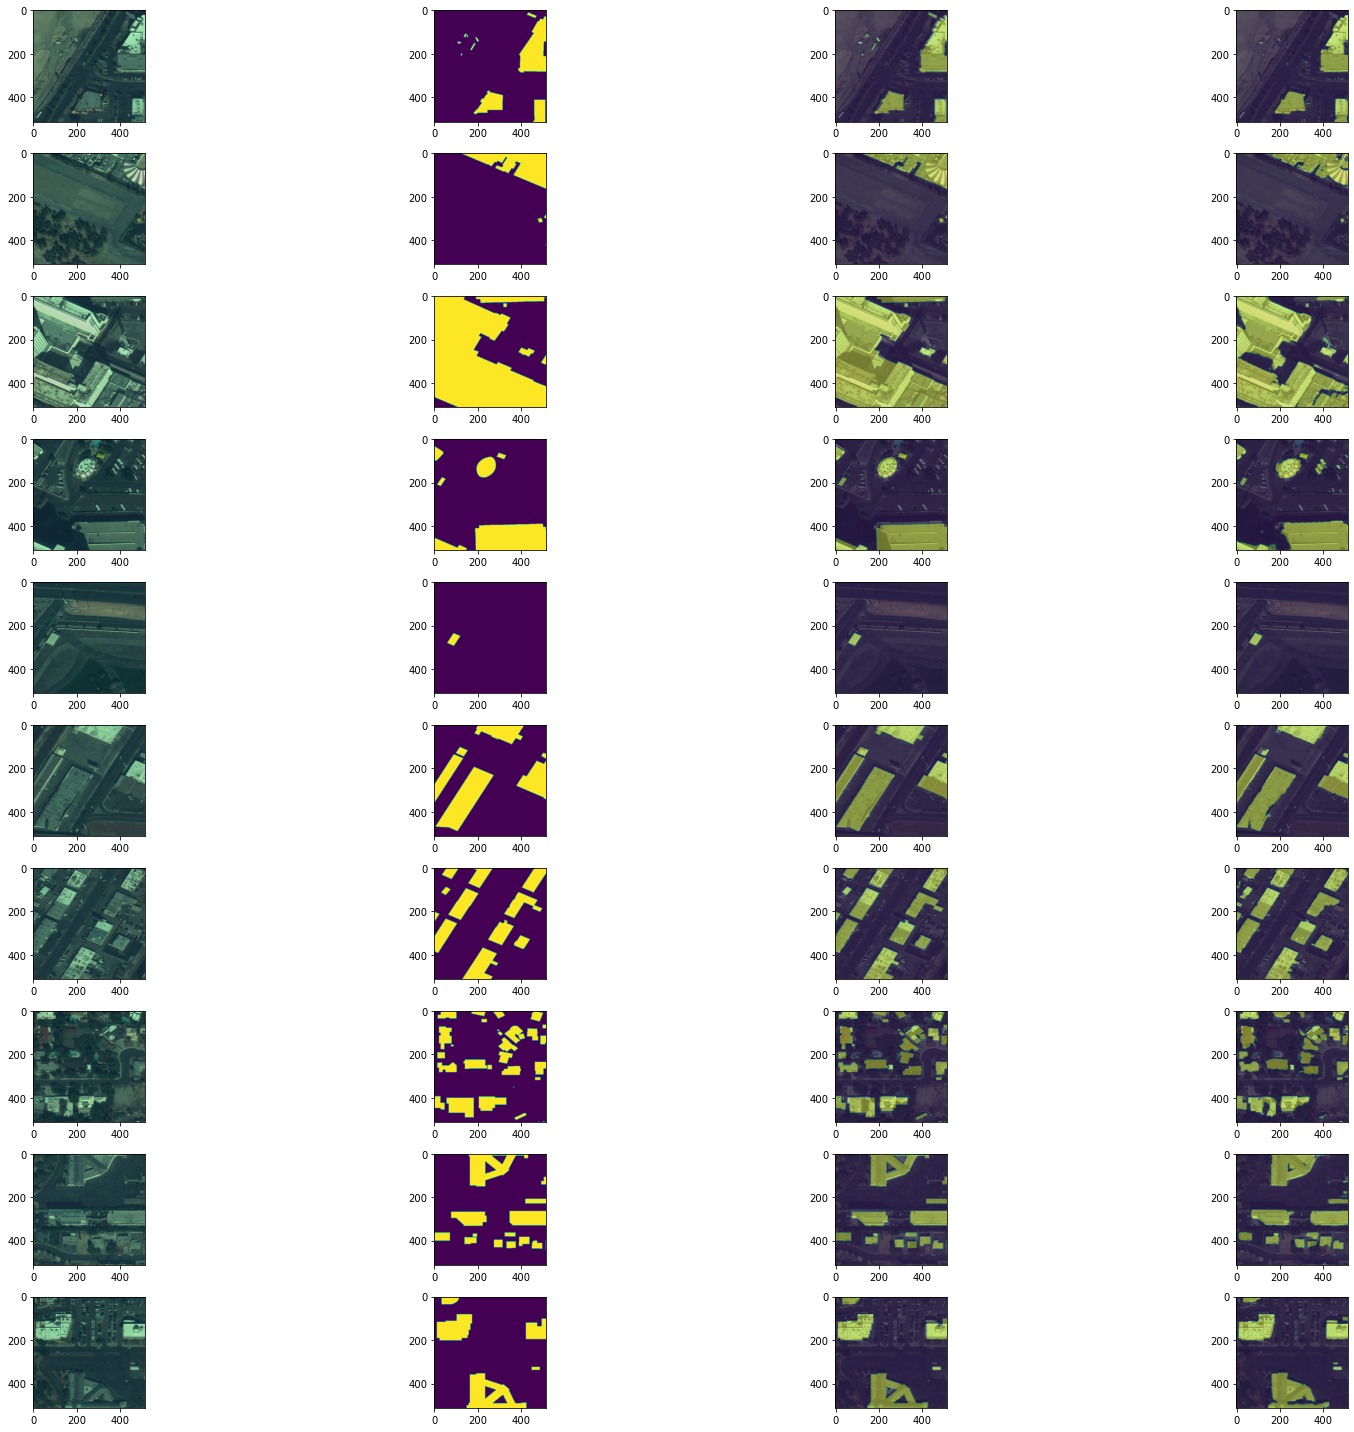

In [30]:
predictions_test = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=test_loader, resume=f"{logdir}/checkpoints/best.pth")
)))
test_images = []
test_masks = []
for batch in test_loader:
    test_images.append(batch['image'])
    test_masks.append(batch['mask'])

test_images = np.vstack(test_images)
test_masks = np.vstack(test_masks)

test_images = np.moveaxis(test_images, 1, -1)
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(5 * 5, 4 * 5))

for i in range(len(test_masks)):
    filename = f"{Path(test_loader.dataset.mask_filepath_list[i]).stem}.tif"
    Image.fromarray(predictions_test[i].squeeze()).resize((650, 650), resample=Image.LANCZOS).save(test_dir/filename)
    
for i in range(10):
    img_normed = (test_images[i] - test_images[i].min())/(test_images[i].max() - test_images[i].min())
    axs[i, 0].imshow(img_normed)
    axs[i, 1].imshow(test_masks[i].squeeze())
    axs[i, 2].imshow(img_normed)
    axs[i, 2].imshow(test_masks[i].squeeze(), alpha=0.4)
    axs[i, 3].imshow(img_normed)
    axs[i, 3].imshow(predictions_test[i].squeeze(), alpha=0.4)
plt.tight_layout();

In [34]:
import pandas as pd
summary_df = pd.read_csv(data_dir / "summary_ids.csv")
summary_df.head()

,image_id,left,bottom,right,top,image_filepath,mask_filepath,has_building,train_val_test
0,AOI_2_Vegas_img1,-115.307518,36.126543,-115.305763,36.128298,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,True,train
1,AOI_2_Vegas_img3,-115.307518,36.130053,-115.305763,36.131808,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,True,train
2,AOI_2_Vegas_img4,-115.307518,36.131808,-115.305763,36.133563,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,True,train
3,AOI_2_Vegas_img7,-115.307518,36.137073,-115.305763,36.138828,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,True,train
4,AOI_2_Vegas_img8,-115.307518,36.138828,-115.305763,36.140583,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,/media/wwymak/Storage/spacenet/AOI_2_Vegas_Tra...,True,train


In [113]:
for i in range(len(test_masks)):
    filename = f"{Path(test_loader.dataset.mask_filepath_list[i]).stem}.png"
    Image.fromarray(predictions_test[i].squeeze()).resize((650, 650)).convert("L").save(test_dir/filename)

In [53]:
# georeferencing-- might not be needed
import shutil
from osgeo import gdal, osr
from fastcore.utils import *


for file in (validation_dir.ls() + test_dir.ls()):
    image_id = file.stem.replace('mask_', '')
    image_info = summary_df[summary_df.image_id==image_id]
    assert len(image_info) ==1
    dataset = gdal.Open(str(file), gdal.GA_Update)
    sr = osr.SpatialReference()
    sr.ImportFromEPSG(4326) 
    # Enter the GCPs
    #   Format: [map x-coordinate(longitude)], [map y-coordinate (latitude)], [elevation],
    #   [image column index(x)], [image row index (y)]
    gcps = [
        gdal.GCP(image_info.left.values[0], image_info.bottom.values[0], 0, 0, 650),
        gdal.GCP(image_info.right.values[0], image_info.bottom.values[0], 0, 650, 650),
        gdal.GCP(image_info.right.values[0], image_info.top.values[0], 0, 650, 0),
        gdal.GCP(image_info.left.values[0], image_info.top.values[0], 0, 0, 0)]

    # Apply the GCPs to the open output file:
    dataset.SetGCPs(gcps, sr.ExportToWkt())
    gdal.Warp(str(file), dataset, dstSRS='EPSG:4326', format='gtiff')

    # Close the output file in order to be able to work with it in other programs:
    dataset = None

In [54]:
# check that the mask is now georeferenced
import rasterio
dataset = rasterio.open(str(test_dir.ls()[10]))
tile_bounds = dataset.bounds
print(tile_bounds)

BoundingBox(left=-115.1530776, bottom=36.22306769989999, right=-115.15132260000001, top=36.22482269989999)


In [142]:
import solaris as sol
pred_path = validation_dir.ls()[0]
mask_image = skimage.io.imread(pred_path)
image_id = pred_path.stem.replace('mask_', '')
image_info = summary_df[summary_df.image_id==image_id]
mask_image = predictions_test[0].squeeze()
geoms = sol.vector.mask.mask_to_poly_geojson(mask_image, bg_threshold=0.5)
# geoms = sol.vector.mask.mask_to_poly_geojson(mask_image, bg_threshold=0.5, reference_im=str(image_info.image_filepath.values[0]), do_transform=True)
geoms.head()

,geometry,value
0,"POLYGON ((511.000 23.000, 511.000 24.000, 510....",255.0
1,"POLYGON ((244.000 373.000, 244.000 374.000, 24...",255.0
2,"POLYGON ((465.000 406.000, 465.000 407.000, 46...",255.0


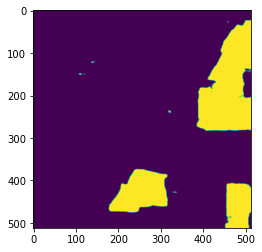

In [122]:
plt.imshow(mask_image)

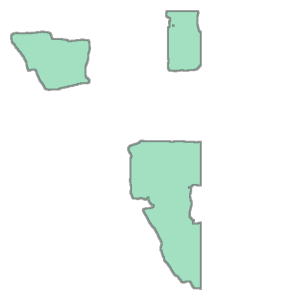

In [123]:
from shapely.ops import cascaded_union
cascaded_union(geoms['geometry'])

In [124]:
 with rasterio.open(str(image_info.image_filepath.values[0])) as ref:
    transform = ref.transform
    crs = ref.crs
    ref.close()

In [125]:
transform, crs

(Affine(2.7000000000043656e-06, 0.0, -115.1723826,
        0.0, -2.699999999993434e-06, 36.1282976997),
 CRS.from_epsg(4326))

In [143]:
# https://github.com/mapbox/rasterio/issues/80
# shapely affine[a, b, d, e, xoff, yoff]
# rasterio affine [xoff, a, b, yoff, d, e]
geoms['geometry'] = geoms['geometry'].affine_transform(( 0.0, -115.1723826,
        2.699999999993434e-06, 36.1282976997,2.7000000000043656e-06, 0))
geoms.crs = crs

In [144]:
geoms['geometry']

0    POLYGON ((-2648.965 830.952, -2764.137 867.081...
1    POLYGON ((-42959.299 13475.856, -43074.471 135...
2    POLYGON ((-46759.987 14668.090, -46875.160 147...
Name: geometry, dtype: geometry